In the present study, we would like to predict weather exoplanet candidates are, in fact,
exoplanets. In order to do this, we use the KEPLER dataset. For each exoplanet candidate, we have
information about a wide range of variables such as orbital period, transit duration, and
Kepler band. We also know the subsequent classification of each candidate (exoplanet or
false positive), this will be our outcome variable.

We will investigate three classification methods to predict if candidates are exoplanets:
(1) Support Vector Machines (SVMs), (2) Random Forest Classifiers (RFCs), and (3) XGB Classifiers
(XGBs). These methods have all worked well in various classification tasks, and are sufficiently
different to be complementary. Note that Python 3.8+ is required! Let's start with the imports.

In [1]:
from collections import OrderedDict
from shutil import rmtree
from tempfile import mkdtemp
from typing import Optional, Union

import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesRegressor, RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, SimpleImputer  # noqa
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor

Below we define the various "grids" of hyperparameter values our models will optimize over.

In [2]:
N_FOLDS = 5  # Number of folds to use in cross-validation

METHODS = {
    'svm': SVC(
        random_state=0,
        probability=True),

    'rfc': RandomForestClassifier(
        random_state=0),

    'xgb': xgb.XGBClassifier(
        random_state=0,
        use_label_encoder=False,
        eval_metric='logloss')}

SVM_GRID = {
    # Kernel type to be used in the algorithm
    'svc__kernel': ['rbf', 'poly', 'sigmoid'],

    # Regularization parameter
    'svc__C': [.01, .1, 1, 10, 100],

    # Kernel coefficient
    'svc__gamma': [.001, .01, .1, 1]}

RFC_GRID = {
    # Number of trees in the random forest
    'n_estimators': list(range(200, 2200, 200)),

    # Number of features to consider at every split
    'max_features': ['auto', 'sqrt'],

    # Maximum number of levels in each tree
    'max_depth': list(range(10, 110, 10)) + [None],

    # Minimum number of samples to split a node
    'min_samples_split': [2, 5, 10],

    # Minimum number of samples required at each leaf node
    'min_samples_leaf': [1, 2, 4],

    # Method of selecting samples for training each tree
    'bootstrap': [True, False]}

# For compatibility with SK Learn pipes.
RFC_GRID = {'randomforestclassifier__' + k: v for k, v in RFC_GRID.items()}

XGB_GRID = {
    # Number of estimators
    'n_estimators': list(range(50, 550, 50)),

    # Learning rate
    'learning_rate': [.01, .03, .1, .3, .6],

    # Minimum loss reduction required for partitioning
    'gamma': [0, 1, 10, 100, 1000],

    # Maximum depth of the tree
    'max_depth': [4, 6, 8, 10],

    # L1 regularization
    'reg_alpha': [.01, .1, 1, 10, 100],

    # L2 regularization
    'reg_lambda': [.01, .1, 1, 10, 100]

}

XGB_GRID = {'xgbclassifier__' + k: v for k, v in XGB_GRID.items()}

# Test grids with fewer parameter values to test the pipeline

SVM_TEST_GRID = {
    'svc__kernel': ['rbf', 'poly'],
    'svc__C': [10, 100],
    'svc__gamma': [.001, .01]}

RFC_TEST_GRID = {
    'randomforestclassifier__n_estimators': [800, 1200],
    'randomforestclassifier__max_features': ['auto', 'sqrt'],
    'randomforestclassifier__max_depth': [50, 60],
    'randomforestclassifier__min_samples_split': [2, 10],
    'randomforestclassifier__min_samples_leaf': [1, 4],
    'randomforestclassifier__bootstrap': [True, False]
}

XGB_TEST_GRID = {
    'xgbclassifier__n_estimators': [100, 300],
    'xgbclassifier__learning_rate': [.01, .6],
    'xgbclassifier__gamma': [1, 10],
    'xgbclassifier__max_depth': [4, 10],
    'xgbclassifier__reg_alpha': [1, 10],
    'xgbclassifier__reg_lambda': [1, 10]
}

The first step will be the data import.

In [3]:
def import_data(fp: str, use_url: bool = True) -> pd.DataFrame:
    """Import Kepler data from csv
    source: https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative

    Args:
        fp: file path to Kepler data
        use_url: use GitHub URL to import data.
    """
    url = 'https://raw.githubusercontent.com/cuboids/adm3/main/cumulative_2021.12.05_03.56.43.csv'
    if use_url:
        return pd.read_csv(url, comment='#')
    return pd.read_csv(fp, comment='#')

The function `first_impression` allows for a cursory view of the data.

In [4]:
def first_impression(df: pd.DataFrame) -> None:
    """View basic descriptive statistics"

    Args:
        df: Pandas dataframe
    """
    print(df.head())
    print(df.describe())
    df.hist()
    plt.show()


First we need to clean the data. In the comments, a brief explanation of each variable is given.
For more detailed information, we refer to the linked exoplanet archive website from Caltech.
Planets from which we do not definitively know if they are an exoplanet or false positive have
been left out.

In [5]:
def basic_data_clean_up(raw: pd.DataFrame, cols: Optional[list[str]] = None) -> pd.DataFrame:
    """Select columns for the feature matrix and code target variable as y

    Args:
        raw: kepler data
        cols: optional list of columns to be included
    """

    # More information about the meaning of each column:
    # https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html
    cols = cols if cols is not None else [
        'kepoi_name',  # KOI Name
        'koi_disposition',  # Exoplanet Archive Disposition
        'koi_period',  # Orbital Period
        'koi_time0bk',  # Transit Epoch [BKJD]
        'koi_impact',  # Impact Parameter
        'koi_duration',  # Transit Duration [hrs]
        'koi_depth',  # Transit Depth [ppm]
        'koi_prad',  # Planetary Radius [Earth radii]
        'koi_teq',  # Equilibrium Temperature [K]
        'koi_insol',  # Insolation Flux [Earth flux]
        'koi_model_snr',  # Transit Signal-to-Noise
        'koi_tce_plnt_num',  # TCE Planet Number
        'koi_steff',  # Stellar Effective Temperature [K]
        'koi_slogg',  # Stellar Surface Gravity [log10(cm/s**2)]
        'koi_srad',  # Stellar Radius [Solar radii]
        'ra',  # RA [decimal degrees]
        'dec',  # Dec [decimal degrees]
        'koi_kepmag']  # Kepler-band [mag]

    # Check that `cols` includes the planet name and disposition
    assert 'kepoi_name' in cols and 'koi_disposition' in cols

    # Only preserve the columns in cols
    df = raw[cols]

    # Planet names need to be unique
    assert len(df['kepoi_name']) == len(set(df['kepoi_name']))

    # Set planet name as row index
    df = df.set_index('kepoi_name')

    # Filter out exoplanet candidates
    df = df[df['koi_disposition'] != 'CANDIDATE']

    # Ensure a planet is either CONFIRMED or FALSE POSITIVE, not a CANDIDATE
    assert len(set(df['koi_disposition'])) == 2

    # Code the target variable as binary
    df['y'] = [int(b) for b in df['koi_disposition'] == 'CONFIRMED']
    df = df.drop('koi_disposition', axis=1)

    return df

It's good practice to compare a baseline "null model". That's what
`baseline_score` does.

In [6]:
def baseline_score(y_train: np.array) -> float:

    # Get predictions on the training set
    baseline_predictions = np.zeros(y_train.shape)

    # Compute MAE
    acc = accuracy_score(y_train, baseline_predictions)
    print(f'Baseline Accuracy: {acc:.3f}')
    print()

    return acc

The functions below are used to actually evaluate each model. First, the dataframe is split
into a training set and a test set. We have chosen for a 70%/30% split so that we have enough
observations in the test set to reliably evaluate the best models.

For all models, we first impute the (likely MNAR) values with an Iterative Imputer. This
means the values are imputed in a round-robin fashion until some convergence criterion is
reached. We do note that Python gives us a ConvergenceWarning, which means that we can't
be certain that the imputed values are correct. Note that we chose to use a Decision Tree
Regressor as our estimator for imputation, as it doesn't make too many assumptions on the
structure of our data and tends to work reasonably well in practice.

After imputation, we applied a Power Transformation. This was necessary, as some of our
variables spanned many orders of magnitude, something which is quite common in astronomical
data. We used the Yeo-Johnson transformations because our data contains both negative and
positive data (Box-Cox transformations work for positive data only).

For Support Vector Machines we use a Cross Validated Grid Search (CVGS) with 5 folds. This type
of hyperparameter tuning works well if the number of possible hyperparameters is reasonably
small, like is the case for SVMs. However, Cross Validated Grid Search quickly becomes
infeasible for grid searches over larger parameter spaces. As both Random Forest
Classifiers and XGBoost Classifiers have many relevant hyperparameters which may influence
model performance, we have chosen to apply a Cross Validated Random Search (CVRS) for those
hyperparameters. An alternative approach uses both CVRS and CVGS on a subset of parameters.

In [7]:
def split_df(df: pd.DataFrame, test_size: float = .3) -> tuple[np.array]:
    """Split dataframe into train and test set

    Args:
        df: kepler data
        test_size: relative size of the test set"""

    X, y = df.drop('y', axis=1).to_numpy(), df['y'].to_numpy()
    return train_test_split(X, y, test_size=test_size, random_state=0)


def cv_grid_search(X_train: np.array, y_train: np.array, method: str, test: bool = True,  # noqa
                   verbose: Optional[bool] = True) -> Union[GridSearchCV, RandomizedSearchCV]:
    """Use cross-validated grid search to find best-fitting parameters

    Args:
        X_train: input variables
        y_train: output variables
        method: classification methods to use ('svm' or 'rfc')
        test: use reduced model for testing purposes
        verbose: print intermediate output
    """

    assert method in ['svm', 'rfc', 'xgb']

    verbose = test if verbose is None else verbose

    estimator = DecisionTreeRegressor(random_state=0)  # Estimator used for imputation
    cachedir = mkdtemp()  # noqa; we cache transformers to avoid repeated computation

    pipe = make_pipeline(
        IterativeImputer(random_state=0, estimator=estimator),
        preprocessing.PowerTransformer(),
        METHODS[method],
        memory=cachedir,
        verbose=verbose)

    # Cross validation settings
    cv = KFold(N_FOLDS, shuffle=True, random_state=0)

    if method == 'svm':
        search = GridSearchCV(
            estimator=pipe,
            param_grid=SVM_TEST_GRID if test else SVM_GRID,
            n_jobs=-1,
            cv=cv,
            verbose=verbose)

    else:
        # Select appropriate grid.
        if method == 'rfc':
            param_distributions = RFC_TEST_GRID if test else RFC_GRID
        else:
            param_distributions = XGB_TEST_GRID if test else XGB_GRID
        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=param_distributions,
            n_iter=10 if test else 100,
            n_jobs=-1,
            cv=cv,
            verbose=verbose,
            random_state=0)

    search.fit(X_train, y_train)
    rmtree(cachedir)
    print(f'Best parameters (CV score={search.best_score_:.3f})')
    print(search.best_params_)

    return search

Below we have defined three objects. The function `main` invokes the previous functions to
do one of two things: (1A) if `compute_optimal_parameters` is set to True (and `test` set to
False) it will run the CVGS or CVRS to find the optimal parameters for the selected model. On the
other hand (1B), if `test` is False, it will use a simplified grid designed to speed up computations.
Finally, (2) with `compute_optimal_parameters` set to False, it will evaluate the optimal
parameters as defined in the dictionary `METHODS_OPTIMAL` with the `evaluate` helper function.

The current values in this dictionary follow directly from running `main` in configuration
1A. We apologize for the fact that these values are hard-coded, however, given the long
compilation time for 1A (~30 minutes for each model), we felt this was the best compromise
between running time and clarity.

In [8]:
METHODS_OPTIMAL = {
    'svm': SVC(
        C=100,
        kernel='rbf',
        gamma=.01,
        random_state=0,
        probability=True),

    'rfc': RandomForestClassifier(
        n_estimators=2000,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='auto',
        max_depth=80,
        bootstrap=False,
        random_state=0),

    'xgb': xgb.XGBClassifier(
        reg_lambda=1,
        reg_alpha=.1,
        n_estimators=500,
        max_depth=8,
        learning_rate=.1,
        gamma=0,
        random_state=0,
        use_label_encoder=False,
        eval_metric='logloss')}

def evaluate(X_train: np.array, y_train: np.array, X_test: np.array, y_test: np.array,
             verbose: bool = True) -> dict[str]:
    """Evaluate optimal models on test set"""

    estimator = DecisionTreeRegressor(random_state=0)  # Estimator used for imputation
    cachedir = mkdtemp()  # noqa; we cache transformers to avoid repeated computation

    scores = {'svm': None, 'rfc': None, 'xgb': None}
    for method in ['svm', 'rfc', 'xgb']:

        pipe = make_pipeline(
            IterativeImputer(random_state=0, estimator=estimator),
            preprocessing.PowerTransformer(),
            METHODS_OPTIMAL[method],
            memory=cachedir,
            verbose=verbose)

        pipe.fit(X_train, y_train)
        scores[method] = pipe.score(X_test, y_test)

    return scores


def main(method: str = 'xgb', test: bool = True, compute_optimal_parameters: bool = False) -> None:
    """

    Args:
        method: Method to use ('svm', 'rfc', or 'xgb')
        test: if true, use a reduced grid for testing the pipeline
        compute_optimal_parameters: recalculate (if true) or evaluate (if false) optimal parameters

    Note: recomputing the optimal parameters on a non-test grid might take 30+ min.

    """

    # Specify file path
    fp = 'cumulative_2021.12.05_03.56.43.csv'

    # Import data
    raw = import_data(fp)

    # Basic data clean-up
    df = basic_data_clean_up(raw)

    # Train-test split
    X_train, X_test, y_train, y_test = split_df(df)  # noqa

    if test:
        print('Descriptive statistics:\n')
        first_impression(df)
        baseline_score(y_test)

    if compute_optimal_parameters:
        cv_grid_search(X_train, y_train, method=method, test=test)
        return

    scores = evaluate(X_train, y_train, X_test, y_test)
    print(scores)

Let's run `main` in configuration (2) to see the test scores for each method.

Descriptive statistics:

            koi_period  koi_time0bk  koi_impact  koi_duration  koi_depth  \
kepoi_name                                                                 
K00752.01     9.488036   170.538750       0.146       2.95750      615.8   
K00752.02    54.418383   162.513840       0.586       4.50700      874.8   
K00754.01     1.736952   170.307565       1.276       2.40641     8079.2   
K00755.01     2.525592   171.595550       0.701       1.65450      603.3   
K00756.01    11.094321   171.201160       0.538       4.59450     1517.5   

            koi_prad  koi_teq  koi_insol  koi_model_snr  koi_tce_plnt_num  \
kepoi_name                                                                  
K00752.01       2.26    793.0      93.59           35.8               1.0   
K00752.02       2.83    443.0       9.11           25.8               2.0   
K00754.01      33.46   1395.0     891.96          505.6               1.0   
K00755.01       2.75   1406.0     926.16           40.9  

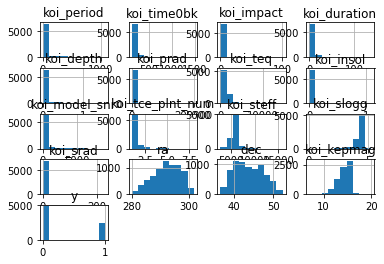

Baseline Accuracy: 0.674



In [ ]:
main()

We achieve about 93% accuracy for each model on the test set, which is not too bad! In fact,
the extra accuracy gained by the Grid Searches wasn't all that much. We conclude that
classifying exoplanet candidates based on astronomical data is doable with reasonable
accuracy.